In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
from io import BytesIO
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [2]:
#define my path in hard drive
# data_dir = "/Volumes/S/Capston/data2"
data_dir = "S:/Capston/data2"
SAVE_FOLDER = "S:/_tmp/"

In [3]:
# Read CSV and making dataframe
df = pd.read_csv(os.path.join(data_dir,'train.csv'))
# sanity check
df.shape

(3147, 15)

In [4]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [6]:
Root = "S:/Capston/data4"
df['path'] = [os.path.join(Root, str(int(patient)) + '.pt') for patient in df['patient_id']]

In [7]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,path
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,S:/Capston/data4\10004.pt
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:/Capston/data4\10005.pt
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:/Capston/data4\10007.pt
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0,S:/Capston/data4\10026.pt
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1,S:/Capston/data4\10051.pt


In [8]:
# sanity check
df.loc[df['extravasation_injury']==df['extravasation_healthy']]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,path


In [9]:

# Separate the data into two DataFrames based on the outcome
df2 = df[['extravasation_injury', 'path']]
df2_y0 = df2.loc[df2['extravasation_injury'] == 0]
df2_y1 = df2.loc[df2['extravasation_injury'] == 1]

# Get the minimum number of samples for balancing
min_samples = min(len(df2_y0), len(df2_y1))

# Sample an equal number of samples from both classes
df_balanced = pd.concat([df2_y0.sample(min_samples, random_state=42), df2_y1.sample(min_samples, random_state=42)])

# Define a function to get random (X, y) pair
# def get_random_X_y_balanced(df):
#     random_row = df.sample(1).iloc[0]
#     tensor = torch.load(random_row['path'])
#     outcome = random_row['extravasation_injury']
    
#     return tensor, outcome

# Generate random (X, y) pairs
X, y = np.array(df_balanced.iloc[:,1]), np.array(df_balanced.iloc[:,0])

# Split your data into remain and testing sets

X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def get_model(width=128, height=128, depth=128):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=128)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 126, 64  1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 63, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 63, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 61, 64)    110656

# Train model

In [11]:

# Split data into training and validation sets
X_train_path, X_val_path, y_train, y_val = train_test_split(X_remain, y_remain, test_size=0.2, random_state=42)
X_train = np.array([torch.load(path).numpy() for path in X_train_path])
X_val = np.array([torch.load(path).numpy() for path in X_val_path])

In [12]:

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [13]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 128, 1)


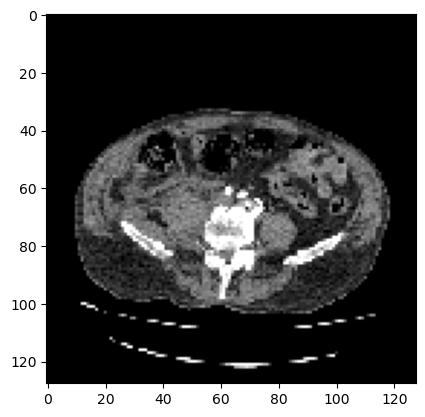

In [14]:
import matplotlib.pyplot as plt
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [15]:

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
128/128 - 673s - loss: 0.7796 - acc: 0.5078 - val_loss: 18.2171 - val_acc: 0.4219 - 673s/epoch - 5s/step
Epoch 2/100
128/128 - 683s - loss: 0.7492 - acc: 0.5117 - val_loss: 0.8904 - val_acc: 0.4219 - 683s/epoch - 5s/step
Epoch 3/100
128/128 - 646s - loss: 0.6994 - acc: 0.5664 - val_loss: 0.9273 - val_acc: 0.3750 - 646s/epoch - 5s/step
Epoch 4/100
128/128 - 652s - loss: 0.7261 - acc: 0.4688 - val_loss: 0.8167 - val_acc: 0.4219 - 652s/epoch - 5s/step
Epoch 5/100
128/128 - 646s - loss: 0.7439 - acc: 0.4844 - val_loss: 0.6765 - val_acc: 0.5625 - 646s/epoch - 5s/step
Epoch 6/100
128/128 - 656s - loss: 0.7108 - acc: 0.5078 - val_loss: 0.7754 - val_acc: 0.4219 - 656s/epoch - 5s/step
Epoch 7/100
128/128 - 668s - loss: 0.7037 - acc: 0.5117 - val_loss: 1.3261 - val_acc: 0.4219 - 668s/epoch - 5s/step
Epoch 8/100
128/128 - 666s - loss: 0.7134 - acc: 0.5312 - val_loss: 0.8197 - val_acc: 0.5625 - 666s/epoch - 5s/step
Epoch 9/100
128/128 - 654s - loss: 0.6982 - acc: 0.5312 - val_loss: 0.7

# Visualizing model performance

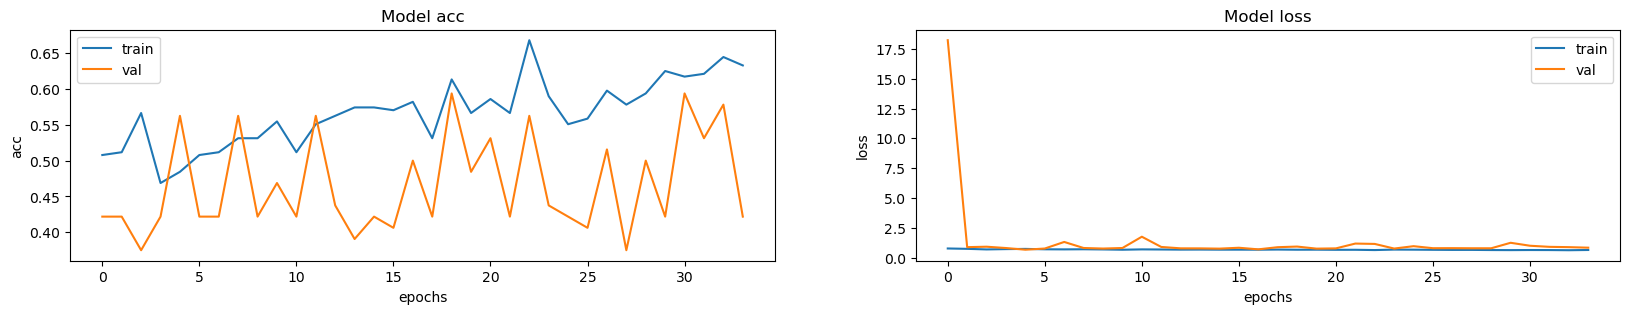

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])